# 17.8 Feature Engineering 2 Assignment
    1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.
    2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?
    3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?
    4. What is the correlation between the overall score variable and the 1st principal component?
    5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?
    
## Import the Data and Fill Data

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                    postgres_user, postgres_pw, postgres_host, 
                    postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation', con=engine)

engine.dispose()
df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [3]:
# filll data initially by year groupby then by interpolate
df = df.groupby('YEAR', as_index=False).apply(
                lambda x: x.fillna(x.mean())).reset_index()

df = df.apply(lambda x: x.interpolate(
                method='linear', limit_direction='forward'))
df = df.apply(lambda x: x.interpolate(
                method='linear', limit_direction='backward'))
df = df.apply(lambda x: x.interpolate(
                method='nearest'))


df.head()

,level_0,level_1,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,0,0,1992_ALABAMA,ALABAMA,1992,727716.0,2678885.0,304177.0,1659028.0,715680.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,263.307067
1,0,1,1992_ALASKA,ALASKA,1992,727716.0,1049591.0,106780.0,720711.0,222100.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,218.410116,266.360319,212.712256,258.859712
2,0,2,1992_ARIZONA,ARIZONA,1992,727716.0,3258079.0,297888.0,1369815.0,1590376.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,0,3,1992_ARKANSAS,ARKANSAS,1992,727716.0,1711959.0,178571.0,958785.0,574603.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,0,4,1992_CALIFORNIA,CALIFORNIA,1992,727716.0,26260025.0,2072470.0,16546514.0,7641041.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,263.307067


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 28 columns):
level_0                         1492 non-null int64
level_1                         1492 non-null int64
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1492 non-null float64
TOTAL_REVENUE                   1492 non-null float64
FEDERAL_REVENUE                 1492 non-null float64
STATE_REVENUE                   1492 non-null float64
LOCAL_REVENUE                   1492 non-null float64
TOTAL_EXPENDITURE               1492 non-null float64
INSTRUCTION_EXPENDITURE         1492 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1492 non-null float64
OTHER_EXPENDITURE               1492 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1492 non-null float64
GRADES_PK_G                     1492 non-null float64
GRADES_KG_G                     1492 

## 1. Create a new score variable from the weighted averages of all score variables in the datasets. 

In [17]:
# calculate the weight ratio of each grade
grade_4_ratio = df['GRADES_4_G'] / (df['GRADES_4_G']+df['GRADES_8_G'])
grade_8_ratio = df['GRADES_8_G'] / (df['GRADES_4_G']+df['GRADES_8_G'])

# calculate the weighted average per grade
weighted_avg_grade_4 = (df['AVG_MATH_4_SCORE']+df['AVG_READING_4_SCORE']) / 2 * grade_4_ratio
weighted_avg_grade_8 = (df['AVG_MATH_8_SCORE']+df['AVG_READING_8_SCORE']) / 2 * grade_8_ratio

# combine for weighted score
df['weighted_score'] = weighted_avg_grade_4 + weighted_avg_grade_8
                        
round(df['weighted_score'], 2).head()

0    232.96
1    237.87
2    235.64
3    235.44
4    230.24
Name: weighted_score, dtype: float64

## 2. What are the correlations between this newly created score variable and the expenditure types?

In [20]:
corr_expense_types = ['weighted_score', 'TOTAL_EXPENDITURE', 
                 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 
                 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']

df[corr_expense_types].corr()

,weighted_score,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
weighted_score,1.000000,0.213045,0.214787,0.229967,0.174515,0.139023
TOTAL_EXPENDITURE,0.213045,1.000000,0.991821,0.992965,0.944919,0.930519
INSTRUCTION_EXPENDITURE,0.214787,0.991821,1.000000,0.977680,0.910143,0.895373
SUPPORT_SERVICES_EXPENDITURE,0.229967,0.992965,0.977680,1.000000,0.949515,0.912790
OTHER_EXPENDITURE,0.174515,0.944919,0.910143,0.949515,1.000000,0.920103
CAPITAL_OUTLAY_EXPENDITURE,0.139023,0.930519,0.895373,0.912790,0.920103,1.000000


## 3. Apply PCA to Expenses

In [26]:
X = df[['INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 
                 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']]

# normalize the data
X = StandardScaler().fit_transform(X)

#transpose x
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00067069 0.97833596 0.91075372 0.89597355]
 [0.97833596 1.00067069 0.95015168 0.91340234]
 [0.91075372 0.95015168 1.00067069 0.92071988]
 [0.89597355 0.91340234 0.92071988 1.00067069]]


In [27]:
# calculate eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# inspecting the values and vectors
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-0.50013765 -0.50764838 -0.49956423 -0.49253531]
Eigenvalue 1: 3.7857624836599535
----------------------------------------
Eigenvector 2: 
[-0.55665059  0.7825781  -0.27607361  0.03866507]
Eigenvalue 2: 0.014716272346022335
----------------------------------------
Eigenvector 3: 
[-0.56484062 -0.35603541  0.22886383  0.70838917]
Eigenvalue 3: 0.12464606766448519
----------------------------------------
Eigenvector 4: 
[ 0.34778949 -0.05570831 -0.78856851  0.5040821 ]
Eigenvalue 4: 0.07755793957568091
----------------------------------------
The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.94580628 0.0036766  0.03114063 0.01937649]


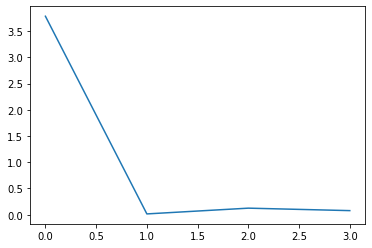

[3.78576248 0.01471627 0.12464607 0.07755794]


In [28]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

### Data Interpretation
Looking at the data above only 1 component should be used for our PCA analysis.

In [32]:
sklearn_pca = PCA(n_components=1)
df['pca'] = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:,0]

# transform X into Y
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94580628]


## 4. What is the correlation between the overall score variable and the 1st principal component?
The correlation is .1953

In [35]:
corr_expense_types = ['weighted_score', 'pca','TOTAL_EXPENDITURE', 
                 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 
                 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']

df[corr_expense_types].corr()

,weighted_score,pca,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
weighted_score,1.000000,0.195275,0.213045,0.214787,0.229967,0.174515,0.139023
pca,0.195275,1.000000,0.992511,0.972793,0.987402,0.971678,0.958007
TOTAL_EXPENDITURE,0.213045,0.992511,1.000000,0.991821,0.992965,0.944919,0.930519
INSTRUCTION_EXPENDITURE,0.214787,0.972793,0.991821,1.000000,0.977680,0.910143,0.895373
SUPPORT_SERVICES_EXPENDITURE,0.229967,0.987402,0.992965,0.977680,1.000000,0.949515,0.912790
OTHER_EXPENDITURE,0.174515,0.971678,0.944919,0.910143,0.949515,1.000000,0.920103
CAPITAL_OUTLAY_EXPENDITURE,0.139023,0.958007,0.930519,0.895373,0.912790,0.920103,1.000000


## 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?
I would use the expenditure variables are those were more highly correlated to the weighted score than the first component. The reason it failed was because PCA does not work well with correlations close to 0 and greater than .7 or .8. 